

score = 0.4862 



In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import os

import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)

In [3]:
cwd = os.getcwd()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=90,
                                      width_shift_range=0.4,
                                      height_shift_range=0.4,
                                      zoom_range=0.5,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect',
                                      brightness_range =[0.8,1.2])
    mask_data_gen = ImageDataGenerator(rotation_range=90,
                                       width_shift_range=0.4,
                                       height_shift_range=0.4,
                                       zoom_range=0.5,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [7]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[512, 384],validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):
    self.png_or_jpg = []
    subset_filenames = []
    subset_direc = []
    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list_ = os.listdir(os.path.join(path,'Images')) # dir is your directory path
        number_files = len(list_)

        training_num_max = int(number_files - int(number_files *  validation_part))
        if which_subset == 'training':
          number_max = training_num_max
          for ii in range(0,number_max):
            subset_filenames.append(os.path.splitext(list_[ii])[0])
            subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)
        elif which_subset == 'validation':
          number_max = number_files - training_num_max
          for ii in range(number_files - 1, number_files - number_max, -1):
            subset_filenames.append(os.path.splitext(list_[ii])[0])
            subset_direc.append(path)
            if project!='Roseau':
              self.png_or_jpg.append(1)
            else:
              self.png_or_jpg.append(0)


    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_direc = subset_direc
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr
  
  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    if self.png_or_jpg[index] != 0:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))
    else:
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    mask = Image.open(os.path.join(curr_dir, 'Masks', curr_filename + '.png'))

    # Resize image 
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)

    mask_arr = np.array(mask)
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    img_arr = np.array(img)
    mask_arr = new_mask_arr

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)


In [8]:
img_h = 384
img_w = 512
dataset = CustomDataset('/content/drive/MyDrive/Development_Dataset/Training/', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None,validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot', 'Mais'])
dataset_valid = CustomDataset('/content/drive/MyDrive/Development_Dataset/Training/', 'validation', 
                              preprocessing_function=None,validation_part=0.2,projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot', 'Mais'])

In [9]:
img_h = 384
img_w = 512

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.shuffle(8, reshuffle_each_iteration=True, seed=SEED)

bs = 20
train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w,1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [10]:
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


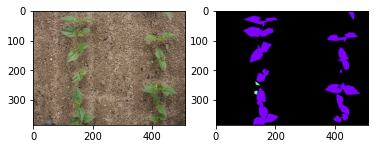

In [11]:


#-------------
#Visualize the images and the masks
#--------------
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [12]:

def create_model(start_f):
  input_shape = [img_h, img_w, 3]
  inputs = tf.keras.Input(shape=(img_h, img_w, 3))
  x_0 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (3,3),
                                strides=(1, 1),
                                padding='same')(inputs)
  x_1 = tf.keras.layers.Conv2D(filters = start_f, 
                                kernel_size = (3,3),
                                strides=(1, 1),
                                padding='same')(x_0)
  input_shape = None


  start_f *= 2
  x_2 = tf.keras.layers.BatchNormalization(axis=-1)(x_1)
  x_3  = tf.keras.layers.Activation('relu')(x_2)
  x_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_3)
  c_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_4)
  x_5 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(c_1)
  x_6 = tf.keras.layers.BatchNormalization(axis=-1)(x_5)
  x_7 = tf.keras.layers.Activation('relu')(x_6)
  x_8 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x_7)



  start_f *= 2

  c_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(x_8)
  x_9 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(c_2)
  y_1 = tf.keras.layers.BatchNormalization(axis=-1)(x_9)
  y_2 = tf.keras.layers.Activation('relu')(y_1)
  y_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(y_2)




  start_f *= 2

  c_3 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(y_3)
  y_4 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(c_3)
  y_5 = tf.keras.layers.BatchNormalization(axis=-1)(y_4)
  y_6 = tf.keras.layers.Activation('relu')(y_5)
  y_7 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(y_6)





  start_f *= 2

  c_4 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(y_7)
  y_8 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(c_4)
  y_9 = tf.keras.layers.BatchNormalization(axis=-1)(y_8)
  z_1 = tf.keras.layers.Activation('relu')(y_9)



  #MIDDLE BLOCK
  m_1 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(z_1)
  m_2 = tf.keras.layers.Conv2D(filters=start_f, 
                      kernel_size=(3, 3),
                      strides = (1,1),
                      padding = 'same')(m_1)
  m_3 = tf.keras.layers.BatchNormalization(axis=-1)(m_2)
  m_4 = tf.keras.layers.Activation('relu')(m_3)





  #DECODER
  start_f = start_f // 2

  d_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(m_4)
  d_3 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1,1), padding='same')(d_2)
  d_4 = tf.keras.layers.ReLU()(d_3)
  d_6 = tf.keras.layers.Add()([d_4,y_6])

  start_f = start_f // 2

  d_7 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(d_6)
  d_8 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1, 1), padding='same')(d_7)
  d_9 = tf.keras.layers.ReLU()(d_8)
  e_1 = tf.keras.layers.Add()([d_9,y_2])


  start_f = start_f // 2
  e_2 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(e_1)
  e_3 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1, 1), padding='same')(e_2)
  e_4 = tf.keras.layers.ReLU()(e_3)
  e_6 = tf.keras.layers.Add()([e_4,x_7])

  start_f = start_f // 2

  e_8 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(2, 2), padding='same')(e_6)
  e_9 = tf.keras.layers.Conv2DTranspose(filters=start_f, kernel_size=(3,3), strides=(1,1), padding='same')(e_8)
  f_1 = tf.keras.layers.ReLU()(e_9)
  f_2 = tf.keras.layers.Add()([f_1,x_3])
  h = tf.keras.layers.Dropout(0.4, seed=SEED)(f_2)


  
  last = tf.keras.layers.Conv2D(filters=3,
                                kernel_size=(1, 1),
                                strides=(1, 1),
                                padding='same',
                                activation='softmax')(h)
  model_1 = tf.keras.Model(inputs=inputs, outputs=last)
  print("first model summary")
  model_1.summary()

  return model_1

  



In [13]:
model=create_model(start_f=55)

first model summary
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 512, 55) 1540        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 512, 55) 27280       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 512, 55) 220         conv2d_1[0][0]                   
__________________________________________________________________________

In [14]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True) 
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    callbacks.append(es_callback)


history = model.fit(x=train_dataset,
          epochs=20,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/20
Epoch 1/20
576/576 [==============================] - 5769s 10s/step - loss: 0.2710 - accuracy: 0.9049 - meanIoU: 0.1957 - val_loss: 0.1756 - val_accuracy: 0.9551 - val_meanIoU: 0.1943
Epoch 2/20
Epoch 2/20
576/576 [==============================] - 5606s 10s/step - loss: 0.1166 - accuracy: 0.9540 - meanIoU: 0.3671 - val_loss: 0.1326 - val_accuracy: 0.9613 - val_meanIoU: 0.3007
Epoch 3/20
Epoch 3/20
576/576 [==============================] - 5532s 10s/step - loss: 0.1025 - accuracy: 0.9617 - meanIoU: 0.4646 - val_loss: 0.1289 - val_accuracy: 0.9624 - val_meanIoU: 0.3132
Epoch 4/20
Epoch 4/20
576/576 [==============================] - 5450s 9s/step - loss: 0.0852 - accuracy: 0.9677 - meanIoU: 0.5379 - val_loss: 0.1190 - val_accuracy: 0.9671 - val_meanIoU: 0.3764
Epoch 5/20
Epoch 5/20
576/576 [==============================] - 5414s 9s/step - loss: 0.0771 - accuracy: 0.9705 - meanIoU: 0.5718 - val_loss: 0.1026 - val_accuracy: 0.9692 - val_meanIoU: 0.3800
Epoch 6/20
Epoch 6/20


In [16]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 384, 512, 3)

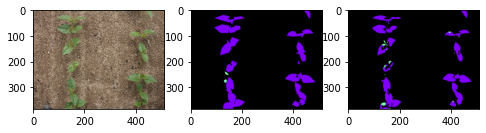

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0] 
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))


predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [19]:
from PIL import Image

class CustomDataSol(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, img_generator=None,
               preprocessing_function=None, out_shape=[512, 384],projects=['Weedelec','Pead','Roseau','Bipbip'],plants=['Haricot','Mais']):

    self.subset_filenames = []
    self.subset_direc = []
    self.name_project = []
    self.name_plant = []
    self.projects = []
    self.plants = []
    self.dataset_dir = dataset_dir
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

    for project in projects :
      for plant in plants :
        path=os.path.join(dataset_dir,project,plant)
        list = os.listdir(os.path.join(path,'Images'))
        number_files = len(list)
        for ii in range(0,number_files):
            self.projects.append(project)
            self.plants.append(plant)
            self.subset_filenames.append(os.path.splitext(list[ii])[0])
            self.subset_direc.append(path)
            self.name_project.append(project)
            self.name_plant.append(plant)
    
  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_dir = self.subset_direc[index]
    curr_project = self.projects[index]
    if curr_project == 'Roseau' :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.png'))
    else :
      img = Image.open(os.path.join(curr_dir, 'Images', curr_filename + '.jpg'))

    # Resize image 
    img = img.resize(self.out_shape)
    img_arr = np.array(img)
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr

################################################################################
 # Encode array (start kit)

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


################################################################################

path_test = '/content/drive/My Drive/Development_Dataset/Test_Dev/'
test_set=CustomDataSol(path_test, 
                        img_generator=img_data_gen,
                        projects=['Weedelec','Pead','Roseau','Bipbip'],
                        plants=['Mais','Haricot'])
test_dataset = tf.data.Dataset.from_generator(lambda: test_set,
                                               output_types= tf.float32,
                                               output_shapes=[img_h, img_w, 3])

test_dataset = test_dataset.batch(1)
iterator = iter(test_dataset)
test_set.__len__()
    
submission_dict = {}
SIZE=[[1536,2048],[2464,3280],[819,1228],[3456,5184]]
for index in range(0,test_set.__len__()):#
      image = next(iterator)
      if test_set.projects[index]=='Bipbip':
        size_im=SIZE[0]
      elif test_set.projects[index]=='Pead':
        size_im=SIZE[1]
      elif test_set.projects[index]=='Roseau':
        size_im=SIZE[2]
      else:
        size_im=SIZE[3]
      img_name = os.path.splitext(test_set.subset_filenames[index])[0]
      submission_dict[img_name] = {}
      mask_arr =  model.predict(image)
      mask_arr = tf.image.resize(mask_arr, size_im, method='nearest')
      #mask_arr.size
      predicted_class = tf.argmax(mask_arr, -1)
      predicted_class = predicted_class[0, ...]
      prediction_img = np.zeros([size_im[0], size_im[1]])
      #prediction_img2 = np.zeros([size_im[0], size_im[1], 3])
  
      prediction_img[np.where(predicted_class == 0)] = 0
      #prediction_img2[np.where(predicted_class == 0)] = [0, 0, 0]
      for i in range(1, 3):
        prediction_img[np.where(predicted_class == i)] = i
        #prediction_img2[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255
      #fig, ax = plt.subplots(1, 2, figsize=(10, 10))
      #fig.show() 
      #print(np.uint8(prediction_img2).size)   
      #ax[0].imshow(np.uint8(prediction_img2))
      #ax[1].imshow(np.uint8(image[0]))
      #fig.canvas.draw()
      #time.sleep(1)

      submission_dict[img_name]['shape'] = size_im
      submission_dict[img_name]['team'] = test_set.projects[index]
      submission_dict[img_name]['crop'] = test_set.plants[index]
      submission_dict[img_name]['segmentation'] = {}
    
    # crop
      rle_encoded_crop = rle_encode(prediction_img == 1)
    # weed
      rle_encoded_weed = rle_encode(prediction_img == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

import json
with open('/content/drive/My Drive/submission.json', 'w') as file:
      json.dump(submission_dict, file)

120

In [20]:
from google.colab import files
files.download("/content/drive/MyDrive/submission.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>